In [1]:
!git clone https://github.com/egemenokte/3DLayeredElastic.git
%cd 3DLayeredElastic/Run
import sys
import os
sys.path.append('..')
from Main.MLEV_Parallel import PyMastic
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
import random

Cloning into '3DLayeredElastic'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 134 (delta 23), reused 0 (delta 0), pack-reused 86 (from 1)
Receiving objects: 100% (134/134), 2.97 MiB | 5.00 MiB/s, done.
Resolving deltas: 100% (59/59), done.
/content/3DLayeredElastic/Run


In [3]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.3 MB/s eta 0:00:00


In [4]:
import pickle
import torch
import json
import time
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
import torch
import logging
import torch.nn as nn
import copy
from torch import nn
from torch.nn import Linear, ReLU,Tanh
from torch_geometric.nn import GCNConv, GATConv
import torch.nn.functional as F
from pathlib import Path

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
file_path = '/content/drive/MyDrive/GAT_LET_Analysis/evaluation/batched_graph_test.pkl'
with open(file_path, 'rb') as fp:
    batched_graph_test = pickle.load(fp)

Load Preprocessed Data

In [12]:
batched_graph_test = torch.load(file_path, map_location='cpu')

Define GAT Model


In [13]:

class GAT(torch.nn.Module):
    def __init__(self,input_dim,hidden_dim1, hidden_dim, output_dim, num_layers,):
        super(GAT,self).__init__()
        torch.manual_seed(1234)
        self.convs = None
        def get_in_channels(idx):
            if idx>1:
                return hidden_dim
            elif idx==1:
                return hidden_dim1
            else:
                return input_dim

        def get_out_channels(idx):
            if idx==0:
                return hidden_dim1
            elif idx>0 and idx<=num_layers-1:
                return hidden_dim
            else:
                return output_dim
        self.convs = torch.nn.ModuleList([
              GATConv(in_channels=get_in_channels(i), out_channels=get_out_channels(i))
              for i in range(num_layers)
          ])

        self.batch_norms = torch.nn.ModuleList([nn.BatchNorm1d(get_out_channels(i)) for i in range(num_layers)])
        self.linear1 = torch.nn.Linear(hidden_dim,hidden_dim)
        self.linear = torch.nn.Linear(hidden_dim, output_dim)
    def forward(self, x, edge_index):

        for i, (gat,batch_norm) in enumerate(zip(self.convs,self.batch_norms)):
            x = gat(x, edge_index)
            x = batch_norm(x)
            x = F.relu(x)
        x=self.linear1(x)
        x=F.relu(x)
        x=self.linear1(x)
        x = F.relu(x)
        out = self.linear(x)
        return out


Set GAT Model Parameters




In [14]:
input_dim =5
hidden_dim1=128
hidden_dim=90
output_dim=3
num_layers=10


 Load Model Checkpoint

In [18]:
path = '/content/drive/MyDrive/GAT_LET_Analysis/pickle/model_epoch_14700.pt'
checkpoint = torch.load(path, map_location='cpu')
model = GAT(input_dim, hidden_dim1, hidden_dim, output_dim, num_layers)

model_state_dict = checkpoint['model_state_dict']
# print(model_state_dict.keys())
model.load_state_dict(model_state_dict)
model.eval()  # Set the model to evaluation mode




GAT(
  (convs): ModuleList(
    (0): GATConv(5, 128, heads=1)
    (1): GATConv(128, 90, heads=1)
    (2-9): 8 x GATConv(90, 90, heads=1)
  )
  (batch_norms): ModuleList(
    (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1-9): 9 x BatchNorm1d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear1): Linear(in_features=90, out_features=90, bias=True)
  (linear): Linear(in_features=90, out_features=3, bias=True)
)

Run Model on Test Graphs

In [19]:
with torch.no_grad():
    batched_graph_test = batched_graph_test.cpu()
    model=model.cpu()
    test_outputs = model(batched_graph_test.x,batched_graph_test.edge_index)

predicted_values = test_outputs.numpy()




 Compute Evaluation Metrics

In [20]:
mse_z = mean_squared_error( batched_graph_test.y[:, 0].cpu().detach().numpy(), predicted_values[:, 0])
mse_r = mean_squared_error( batched_graph_test.y[:, 1].cpu().detach().numpy(), predicted_values[:, 1])
mse_t = mean_squared_error( batched_graph_test.y[:, 2].cpu().detach().numpy(), predicted_values[:, 2])
mae_z = mean_absolute_error( batched_graph_test.y[:, 0].cpu().detach().numpy(), predicted_values[:, 0])
mae_r = mean_absolute_error(batched_graph_test.y[:, 1].cpu().detach().numpy(), predicted_values[:, 1])
mae_t = mean_absolute_error(batched_graph_test.y[:, 2].cpu().detach().numpy(), predicted_values[:, 2])

mape_z = mean_absolute_percentage_error(batched_graph_test.y[:, 0].cpu().detach().numpy(), predicted_values[:, 0])
mape_r = mean_absolute_percentage_error(batched_graph_test.y[:, 1].cpu().detach().numpy(), predicted_values[:, 1])
mape_t = mean_absolute_percentage_error(batched_graph_test.y[:, 2].cpu().detach().numpy(), predicted_values[:, 2])


Print MAE Results

In [21]:
print(mae_z ,mae_r ,mae_t)

1.7598146200180054 0.7835447192192078 0.7724579572677612


 Plot Actual vs Predicted Strain

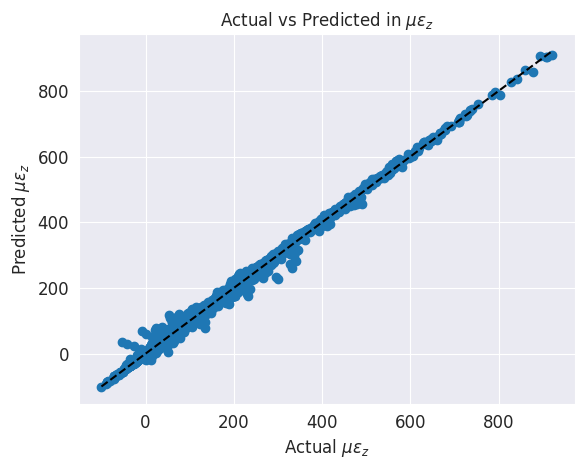

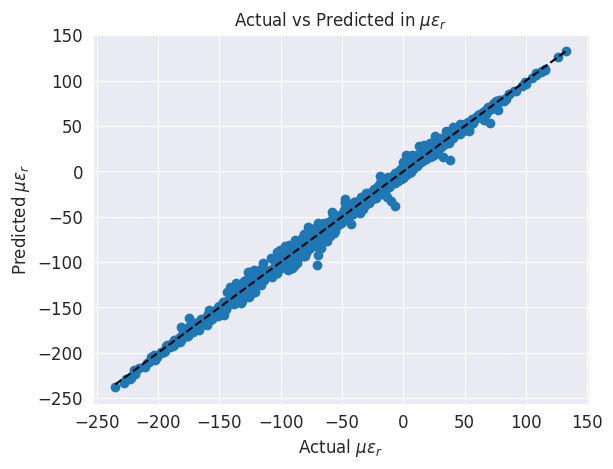

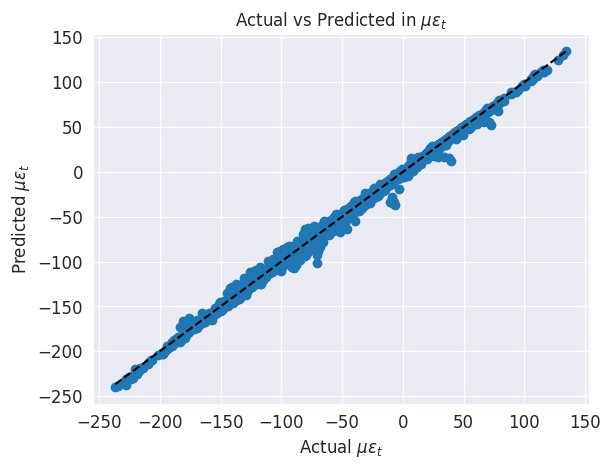

In [22]:
sns.set_style("darkgrid")


stress_z = batched_graph_test.y[:,0]

plt.scatter(stress_z, predicted_values[:,0])
p1= max(max(stress_z), max(stress_z))
p2=min(min(stress_z), min(stress_z))
plt.plot([p2,p1],[p2,p1],color='black', linestyle='--')
plt.xlabel(r'Actual $\mu\epsilon_z$', fontsize=12)
plt.ylabel(r'Predicted $\mu\epsilon_z$', fontsize=12)
plt.title(r'Actual vs Predicted in $\mu\epsilon_z$')

# Set tick parameters with font size 12 pt
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()
plt.close()

stress_r = batched_graph_test.y[:,1]
plt.scatter(stress_r, predicted_values[:,1])
p1= max(max(stress_r), max(stress_r))
p2=min(min(stress_r), min(stress_r))
plt.plot([p2,p1],[p2,p1],color='black', linestyle='--')
plt.xlabel(r'Actual $\mu\epsilon_r$', fontsize=12)
plt.ylabel(r'Predicted $\mu\epsilon_r$', fontsize=12)
plt.title(r'Actual vs Predicted in $\mu\epsilon_r$')

# Set tick parameters with font size 12 pt
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()
plt.close()

stress_t = batched_graph_test.y[:,2]
plt.scatter(stress_t, predicted_values[:,2])
p1= max(max(stress_t), max(stress_t))
p2=min(min(stress_t), min(stress_t))
plt.plot([p2,p1],[p2,p1],color='black', linestyle='--')
plt.xlabel(r'Actual $\mu\epsilon_t$', fontsize=12)
plt.ylabel(r'Predicted $\mu\epsilon_t$', fontsize=12)
plt.title(r'Actual vs Predicted in $\mu\epsilon_t$')

# Set tick parameters with font size 12 pt
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()
plt.close()

Organize Predictions by Structure

In [23]:
pred_graph ={}
current_index = 0
for i in range(batched_graph_test.batch_size):
    res_test= len(batched_graph_test[i].y)

    pred_values = predicted_values[current_index:current_index+res_test]

    pred_graph[i]=pred_values
    current_index+=res_test



Select Test Structure.

Change the number of test_struct and test_g_struct to generate the evaluation for different structures in test set

In [24]:
test_struct=0
test_g_struct=0

Load Z-Coordinates

In [25]:

with open('/content/drive/MyDrive/GAT_LET_Analysis/training/ZS_test', 'rb') as fp:
    ZS_new = pickle.load(fp)

Convert Inches to cm

In [26]:
ZS_converted = [i*2.54 for i in ZS_new]

Load X-Coordinates

In [27]:

with open('/content/drive/MyDrive/GAT_LET_Analysis/training/xs', 'rb') as fp:
    xs = pickle.load(fp)

In [28]:
xs

array([ 0.5       ,  0.96021096,  1.56925807,  2.32714132,  3.23386073,
        4.28941629,  5.49380799,  6.84703584,  8.34909985, 10.        ])

To convert to SI units

 Convert xs to Centimeters

In [29]:
xs_converted= xs*2.54

In [30]:
xs_converted

array([ 1.27      ,  2.43893583,  3.98591549,  5.91093896,  8.21400625,
       10.89511736, 13.95427229, 17.39147104, 21.20671361, 25.4       ])

Round Coordinates

In [31]:
xs=np.round(xs_converted,2)
ZS_new=[np.round(zs,2) for zs in ZS_converted]

Heatmaps for Actual and Predicted Strains

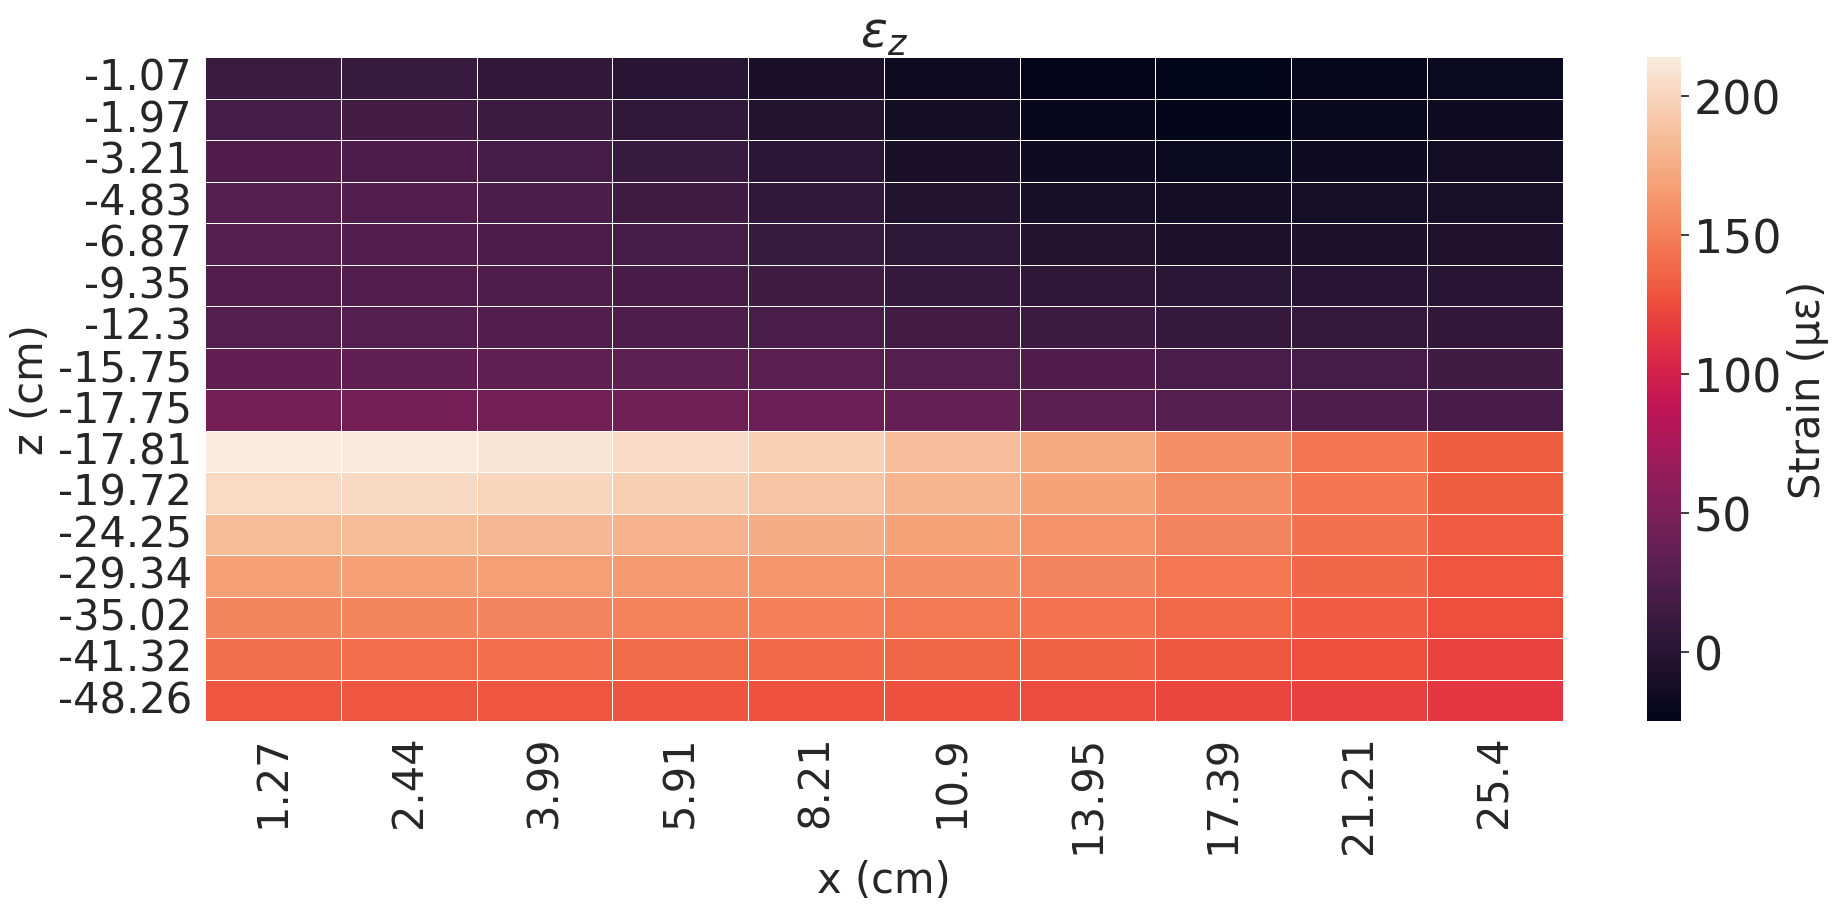

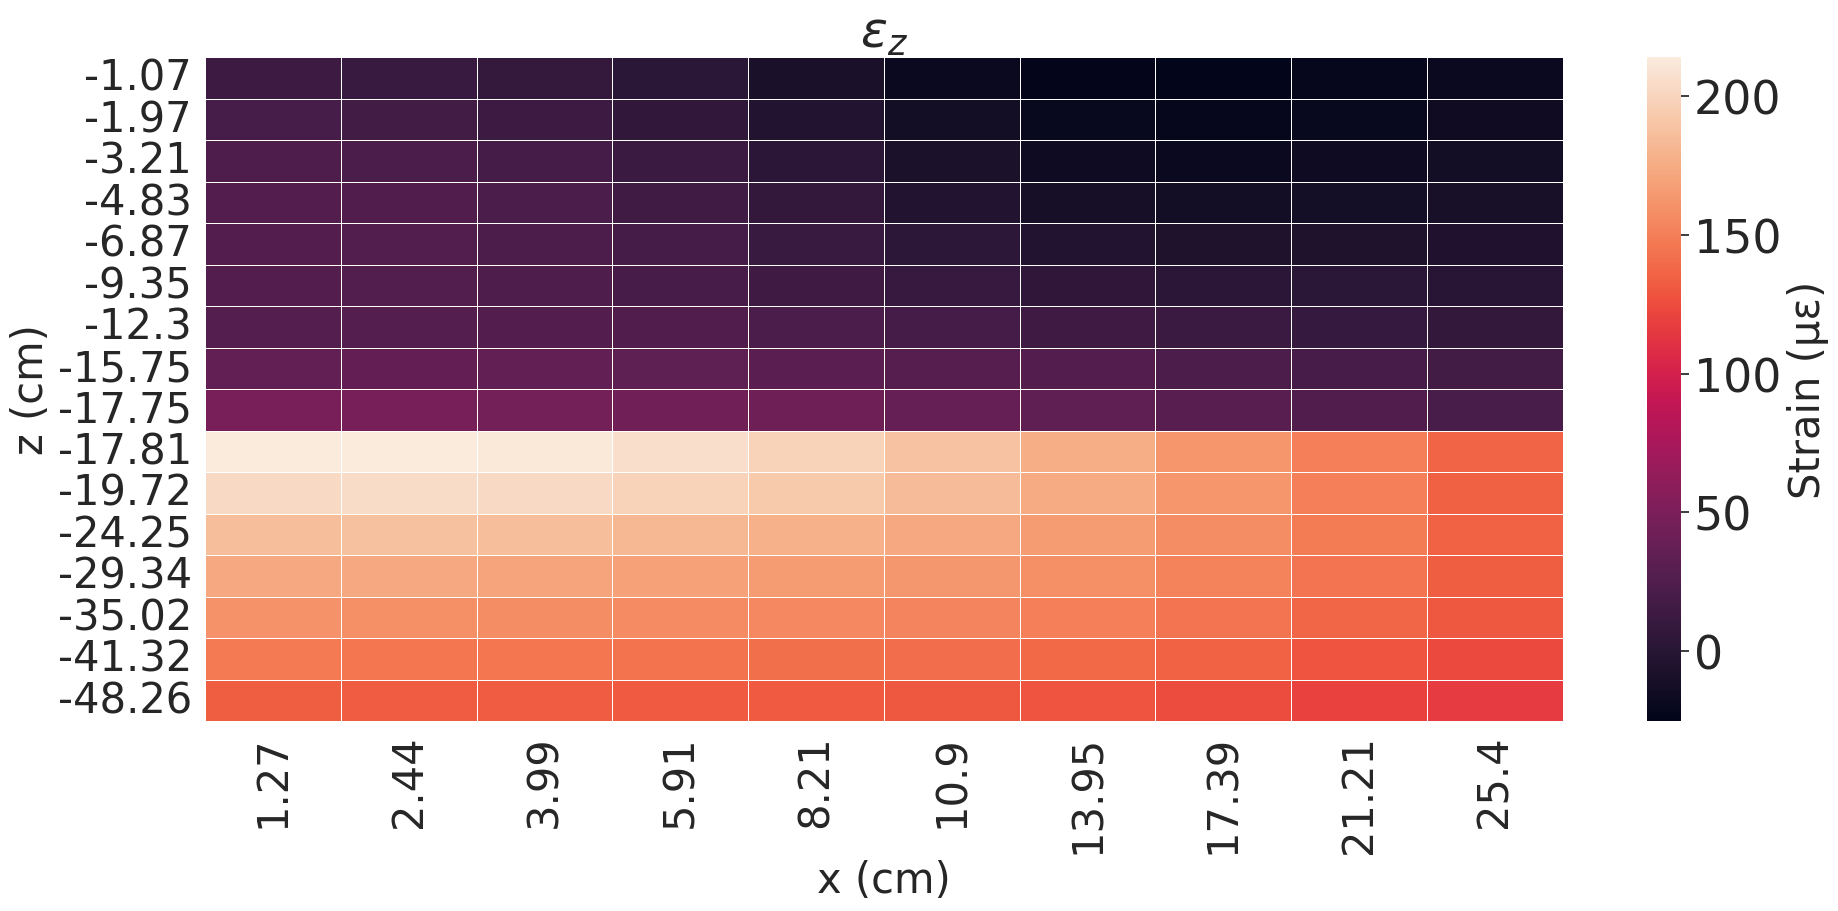

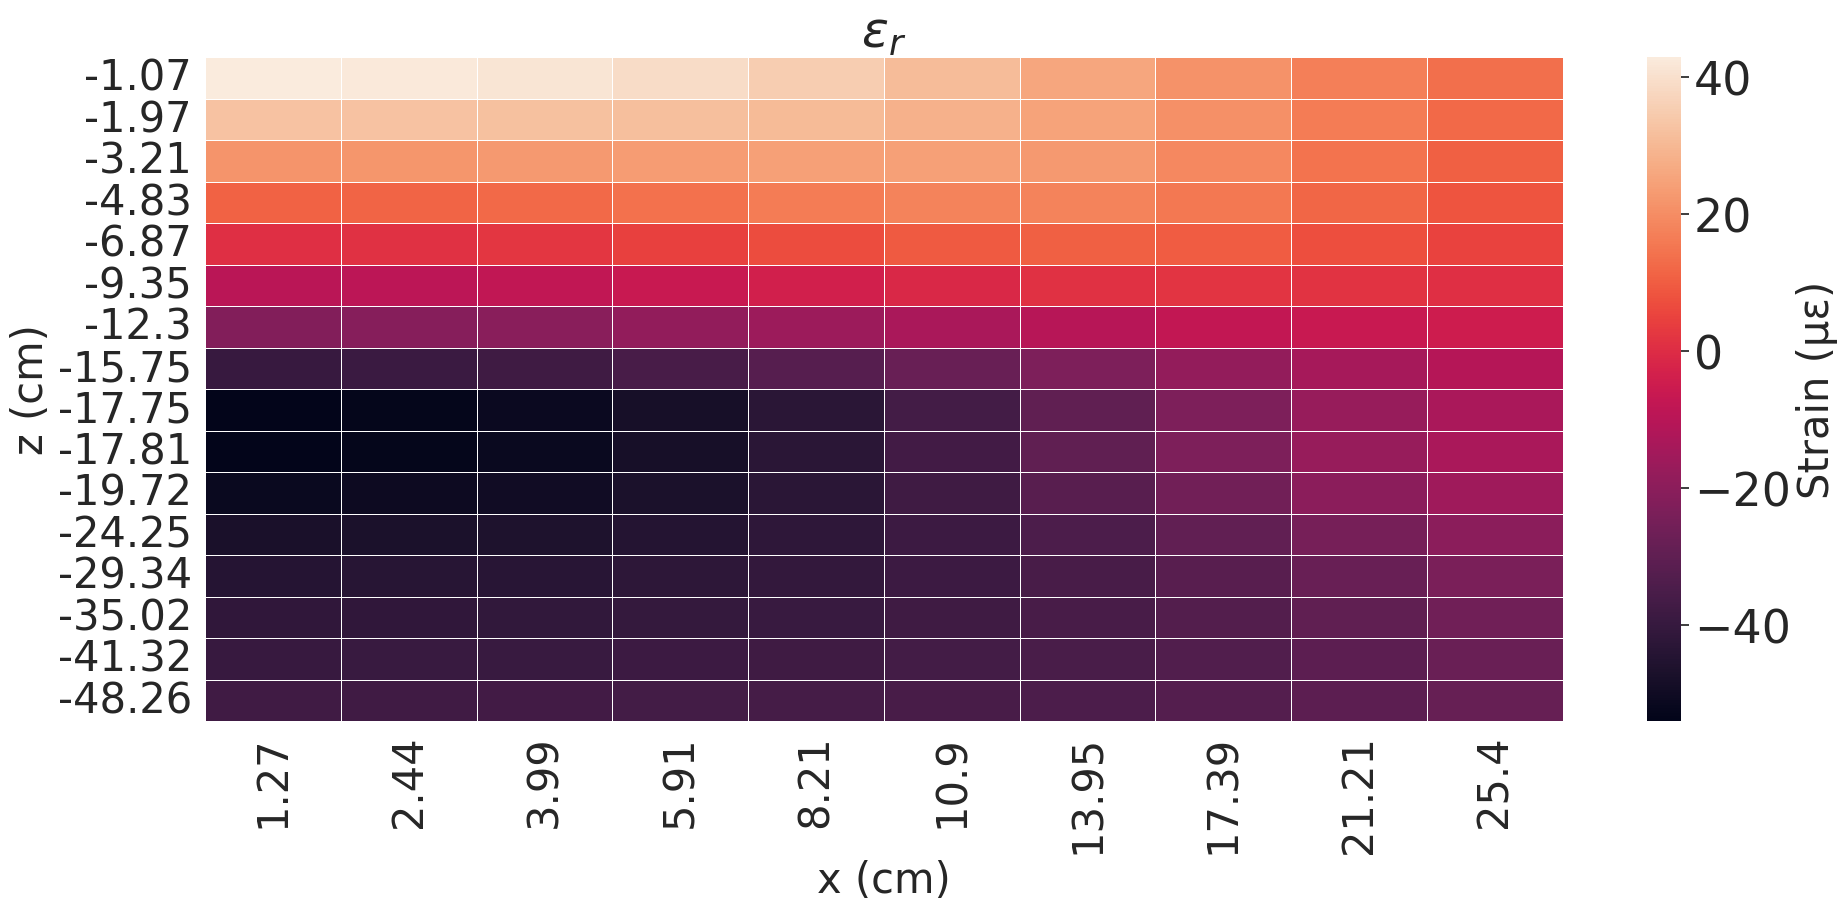

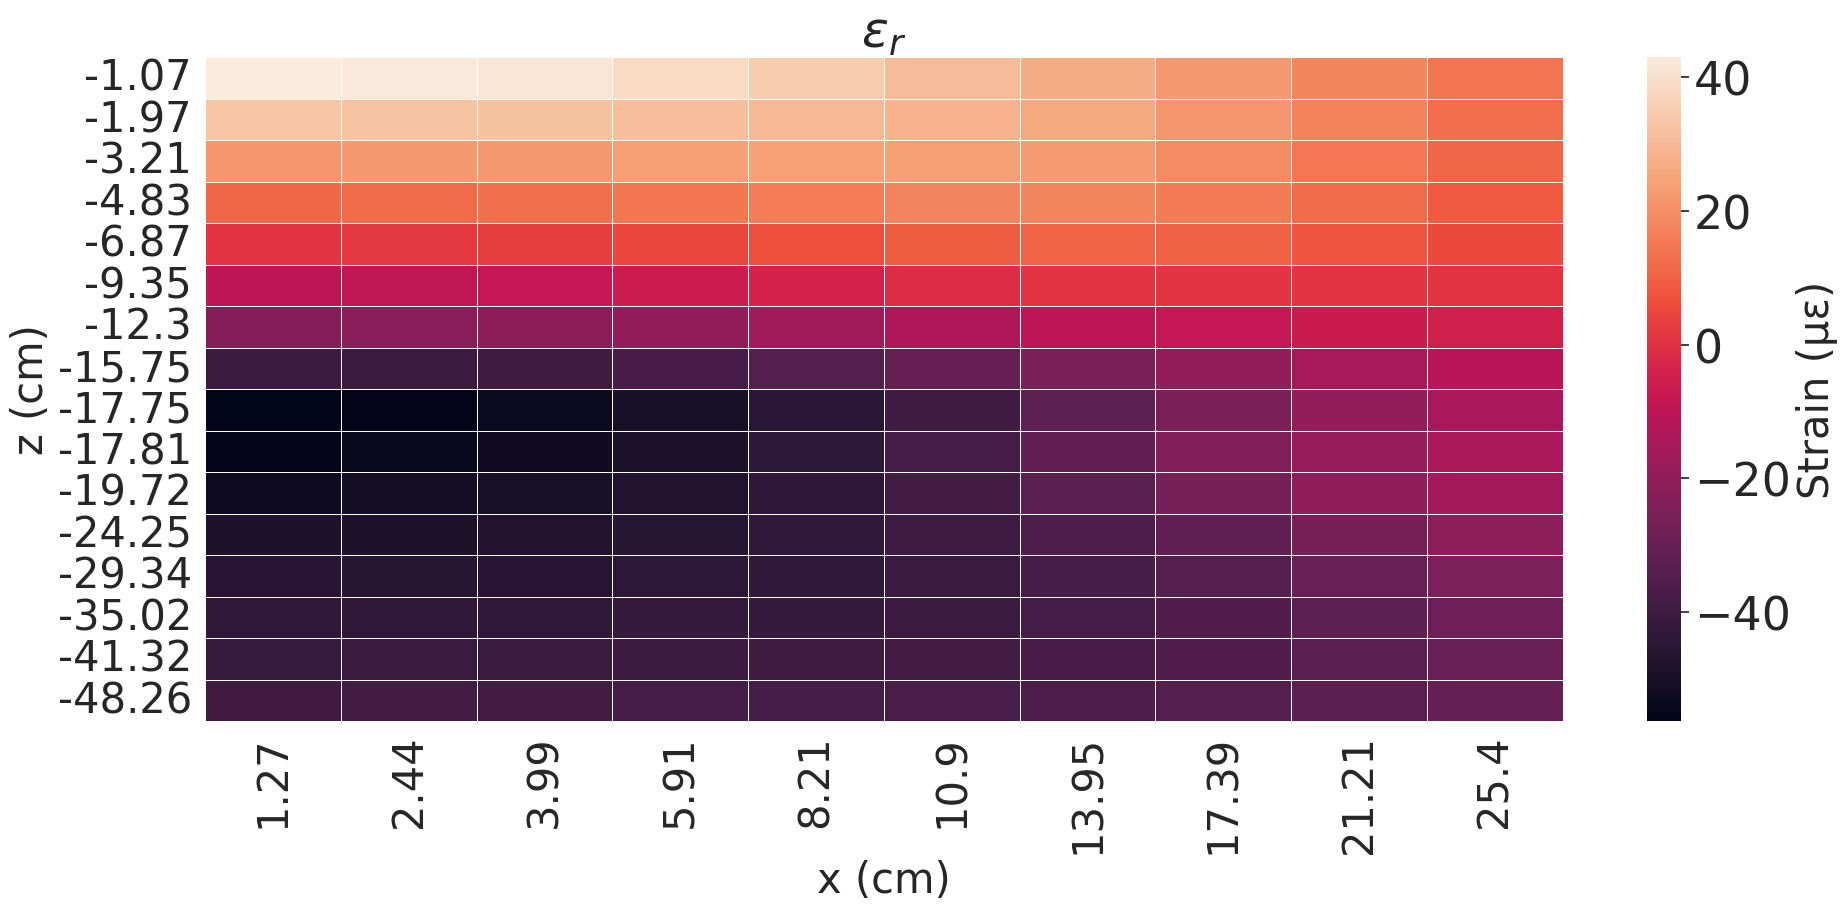

In [32]:

sns.set(rc={'figure.figsize':(20,10)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_Z'
A_prep=np.reshape(batched_graph_test[test_g_struct].y[:,0],(len(ZS_new[test_struct]),len(xs)))
heatmap = sns.heatmap(A_prep, linewidths=.5,xticklabels=xs,yticklabels=-z,  # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30)
plt.xlabel('x (cm)', fontsize=30)  # X-axis label font size
plt.ylabel('z (cm)', fontsize=30)  # Y-axis label font size
plt.title(r'$\epsilon_z$')
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30)
plt.tight_layout()
plt.show()
plt.close()


sns.set(rc={'figure.figsize':(20,10)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_Z'
A_bar=np.reshape(pred_graph[test_struct][:,0],(len(ZS_new[test_struct]),len(xs)))
heatmap = sns.heatmap(A_bar, linewidths=.5,xticklabels=xs,yticklabels=-z,   # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30)
plt.xlabel('x (cm)', fontsize=30)  # X-axis label font size
plt.ylabel('z (cm)', fontsize=30)  # Y-axis label font size
plt.title(response)
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30)
plt.title(r'$\epsilon_z$')
plt.tight_layout()
plt.show()
plt.close()




sns.set(rc={'figure.figsize':(20,10)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_R'
A_prep=np.reshape(batched_graph_test[test_g_struct].y[:,1],(len(ZS_new[test_struct]),len(xs)))
heatmap=sns.heatmap(A_prep, linewidths=.5,xticklabels=xs,yticklabels=-z,  # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30)
plt.xlabel('x (cm)', fontsize=30)  # X-axis label font size
plt.ylabel('z (cm)', fontsize=30)  # Y-axis label font size
plt.title(response)
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30)
plt.title(r'$\epsilon_r$')
plt.tight_layout()
plt.show()
plt.close()



sns.set(rc={'figure.figsize':(20,10)},font_scale=3)
z=np.array(ZS_new[test_struct])
response='Strain_R'
A_bar=np.reshape(pred_graph[test_struct][:,1],(len(ZS_new[test_struct]),len(xs)))
heatmap=sns.heatmap(A_bar, linewidths=.5,xticklabels=xs,yticklabels=-z,  # Annotation font size
            cbar_kws={'label': 'Strain (µε)'})  # Colorbar label font size
colorbar = heatmap.collections[0].colorbar
colorbar.ax.yaxis.label.set_size(30)
plt.xlabel('x (cm)', fontsize=30)  # X-axis label font size
plt.ylabel('z (cm)', fontsize=30)  # Y-axis label font size
plt.title(response)
plt.xticks(fontsize=30)  # X-axis ticks font size
plt.yticks(fontsize=30)
plt.title(r'$\epsilon_r$')
plt.tight_layout()

plt.show()
plt.close()


